# Quinoa Seed Analysis Tutorial

This is a full workflow that shows methods for counting and analyzing the shape and color of seeds. Similar methods should work for other types of seeds.

# Section 1: Importing libraries and image

In [57]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [58]:
#Import libraries

%matplotlib notebook
import os
import argparse
import matplotlib
import cv2
import numpy as np

from plantcv import plantcv as pcv

## Input variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [59]:
# Input image into self.image (include file path if image is not in 
# the same folder as jupyter notebook)

# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

class options:
    def __init__(self):        
        self.image = "/Users/adrianethompson/Documents/REU2021/plantcv-binder/notebooks/img/tutorial_images/seed/quinoa_seeds.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "seed_analysis_results"
        self.outdir = "."

In [60]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

<IPython.core.display.Javascript object>


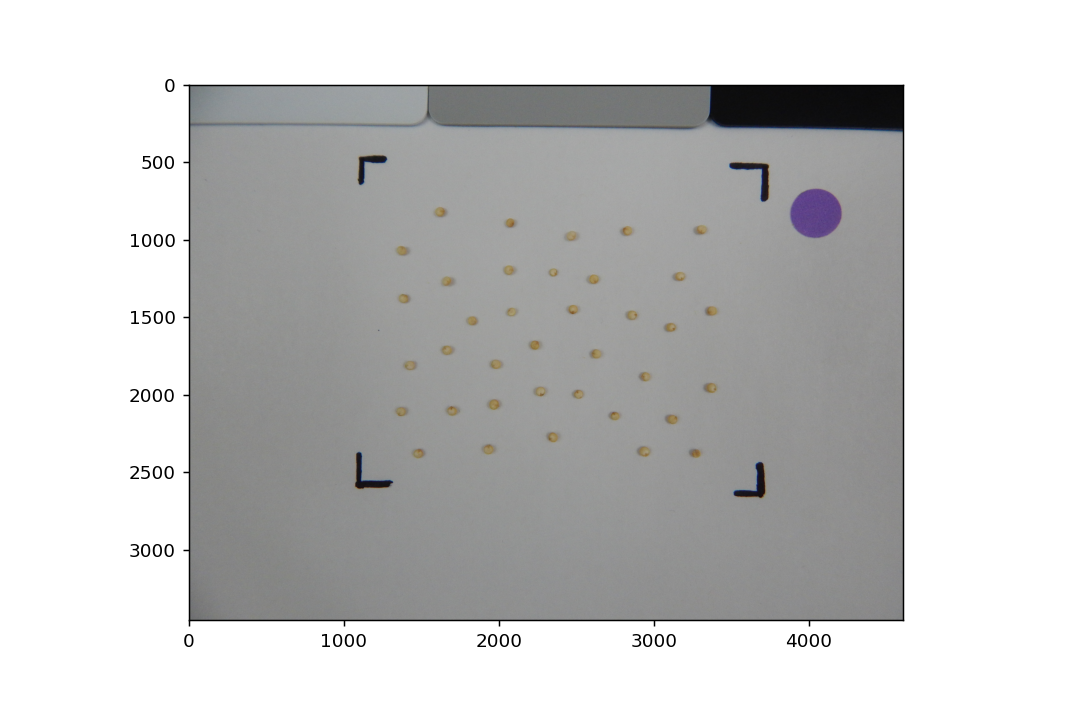

In [61]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Segmenting plant from background and identifying plant object(s)

* Requires successful import of image
* See Threshold Tools Tutorial tutorial for other functions that can be used to create a binary mask

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

<IPython.core.display.Javascript object>


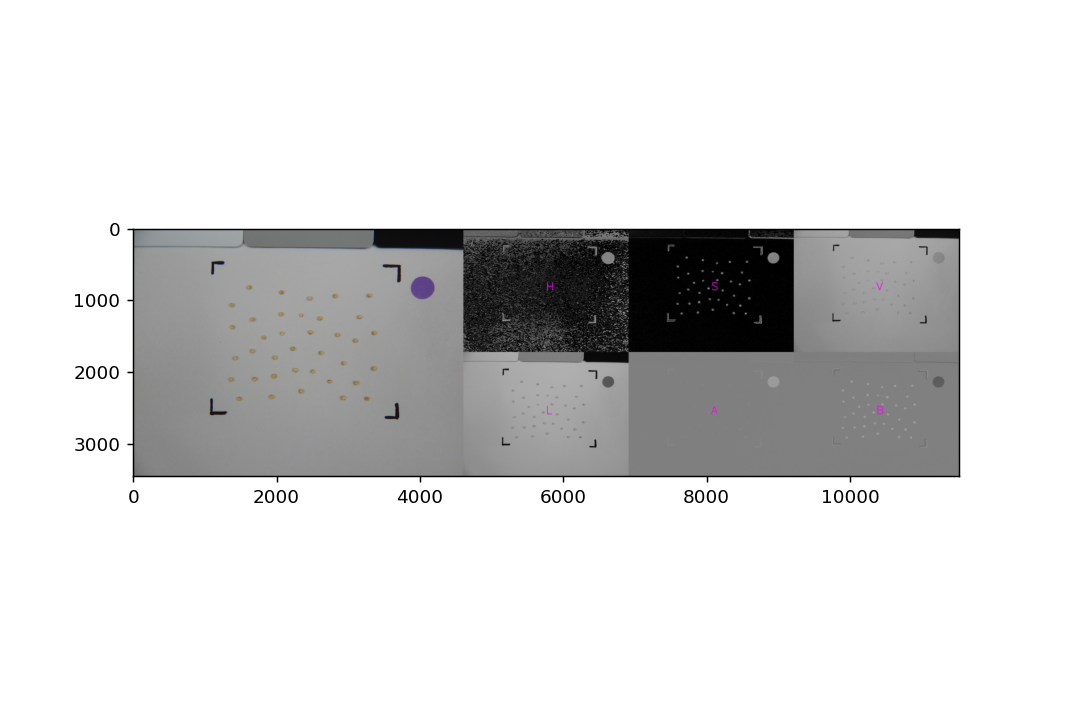

In [62]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)

## Crop image

Cropping out aspects of the image that may interfere with the binary mask makes it easier to isolate plant material from background.

<IPython.core.display.Javascript object>


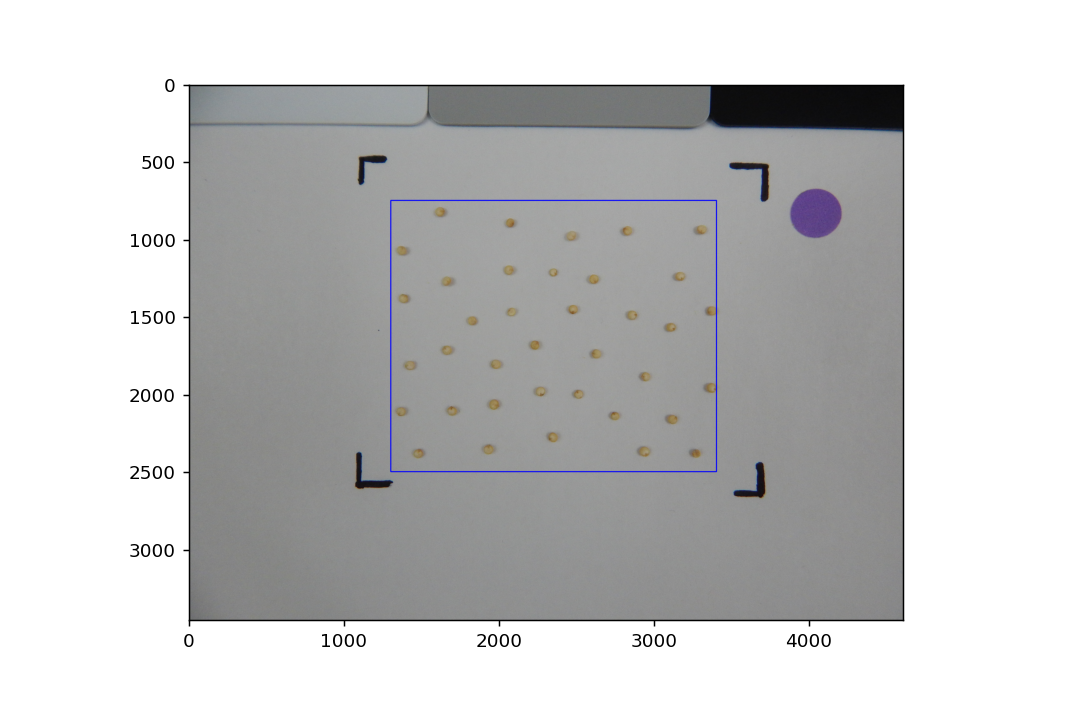

In [63]:
# Inputs:
#   x = top left x-coordinate
#   y = top left y-coordinate
#   h = height of final cropped image
#   w = width of final cropped image
img = pcv.crop(img=img, x=1300, y=750, h=1750, w=2100)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.

<IPython.core.display.Javascript object>


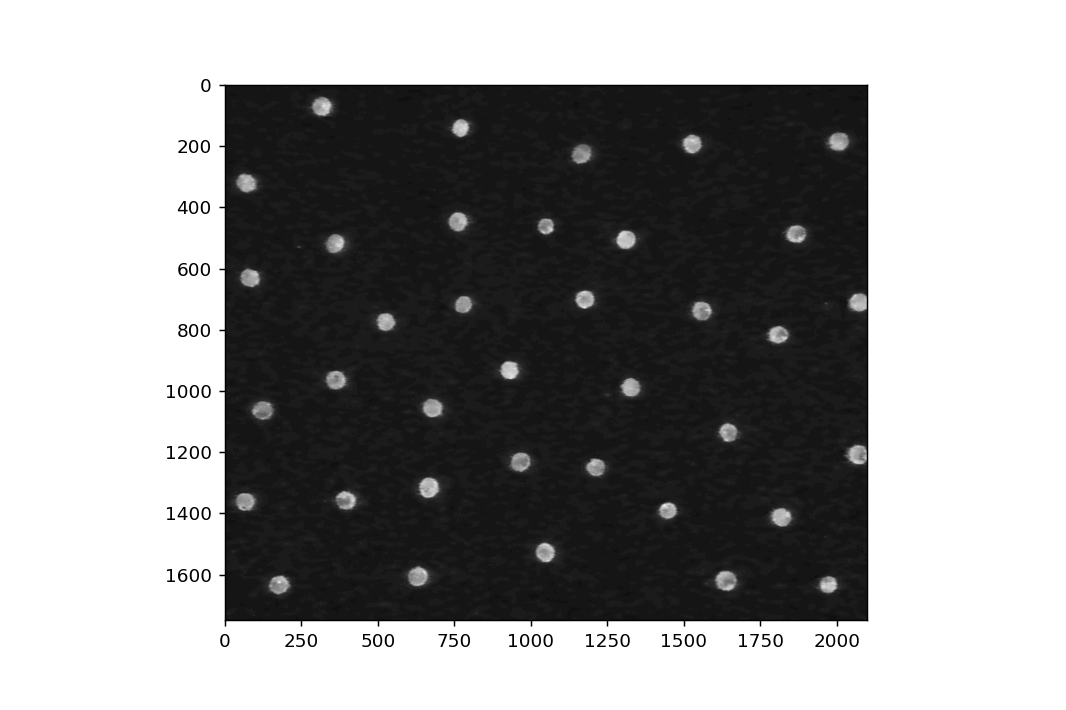

In [64]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
b_img = pcv.rgb2gray_lab(rgb_img=img, channel='b')

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 125-130 are from the darker background pixels. The smaller peak between 150-160 are the lighter seed pixels.

<IPython.core.display.Javascript object>


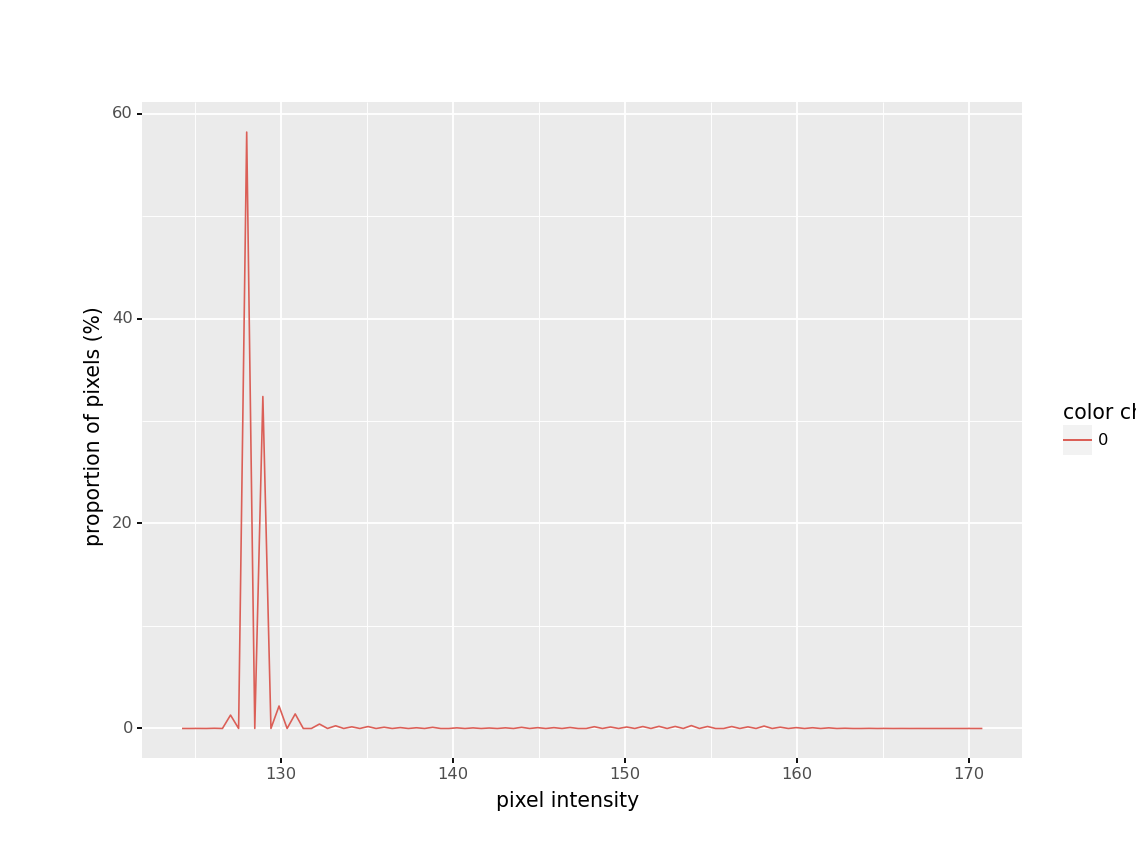

In [65]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=b_img)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 130-150 will segment the plant and background peaks. Because the seeds are the lighter pixels in this image, use object_type="light" to do a traditional threshold.

<IPython.core.display.Javascript object>


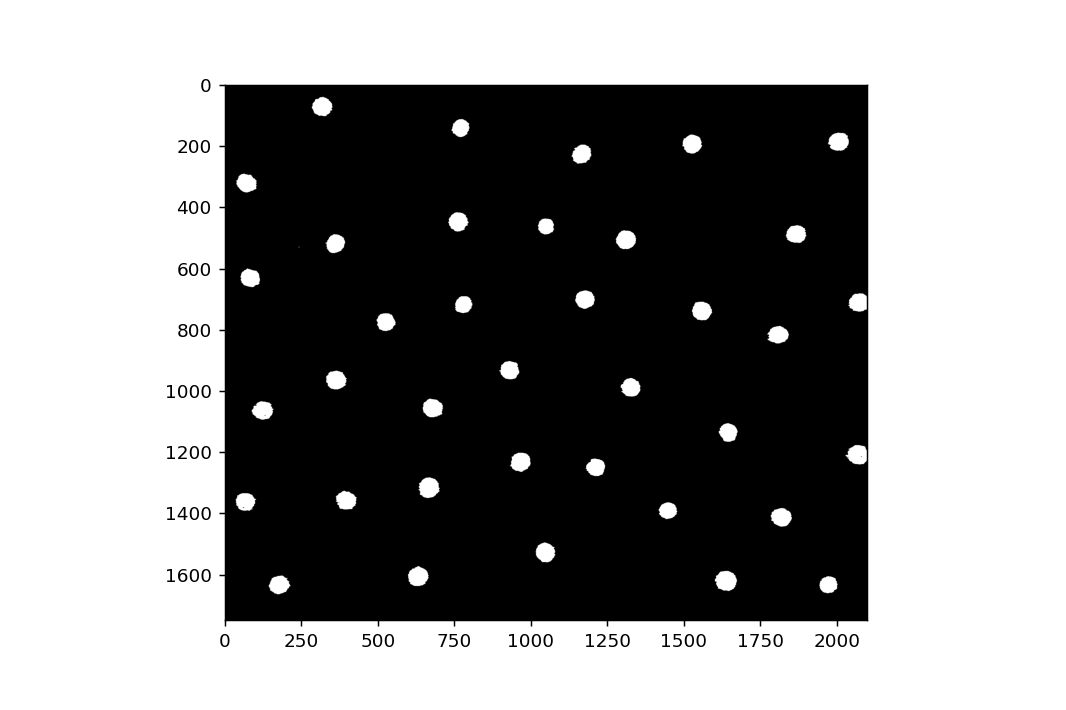

In [66]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
b_thresh = pcv.threshold.binary(gray_img=b_img, threshold=140, max_value=255, object_type='light')
#                                                          ^                                 ^
#                                                          |                                 |
#                                                  change this value                  change this value


## Remove small background noise

Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size.

<IPython.core.display.Javascript object>


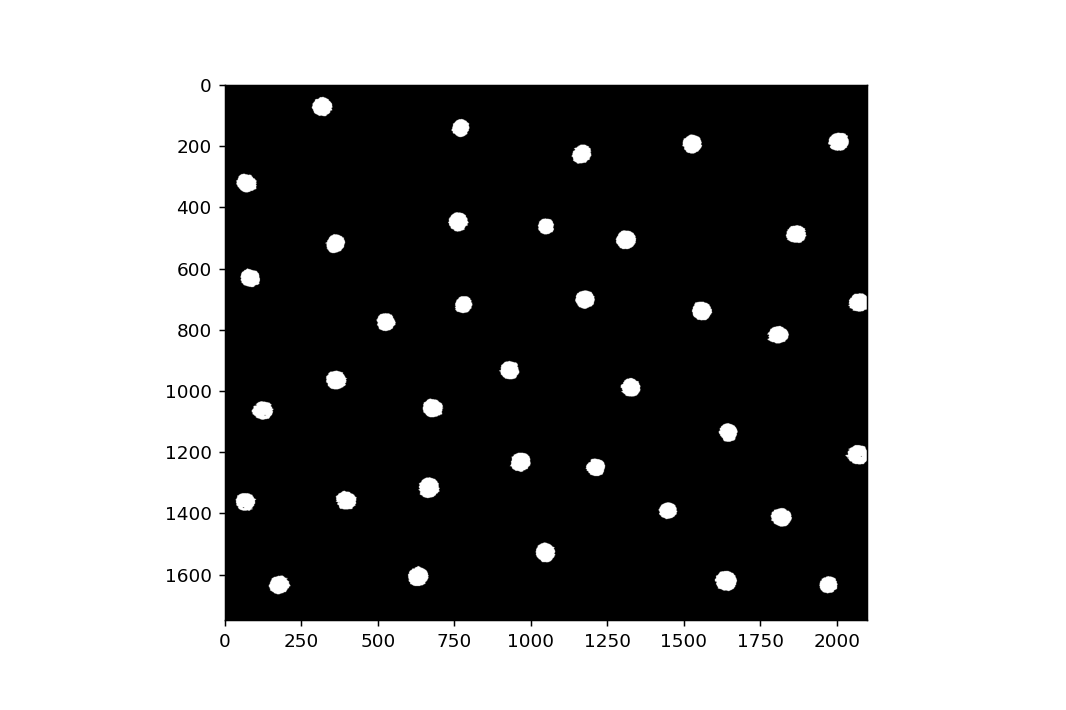

In [67]:
# Inputs:
#   bin_img - binary mask image
#   size - maximum size for objects that should be filled in as background (non-plant) pixels
b_fill = pcv.fill(bin_img=b_thresh, size=300)
#                                         ^
#                                         |
#                                 change this value

# Section 3: Count and Analyze Seeds

* Need a completed binary mask

## Identify simple seed objects

The binary mask can be used to find objects, or contours, each of which will outline a seed. Unlike the PlantCV find_objects function, this uses findContours from OpenCV with the input cv2.RETR_EXTERNAL to ignore layered contours. The output from this step can be used to count seeds, but CANNOT be used as input for shape and color analysis. 

In [68]:
# Inputs:
#   mask = binary mask with extra noise filled in
objects = cv2.findContours(b_fill, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

## Count seeds

Count the number of seeds (simple objects) by accessing the number of values stores in the second item of the object list.

In [69]:
# Find number of seeds

# Inputs:
#    contours = list of contours
number_seeds = len(objects[1])

## Identify seed objects for shape and color analysis

For shape and color analysis, we need to use find_objects from PlantCV to get the objects and object hierarchy that we need as inputs in the following analyses. OpenCV findContours and PlantCV find_objects do not behave in the same way or provide the same outputs, which is why we must identify objects twice in this workflow.

<IPython.core.display.Javascript object>


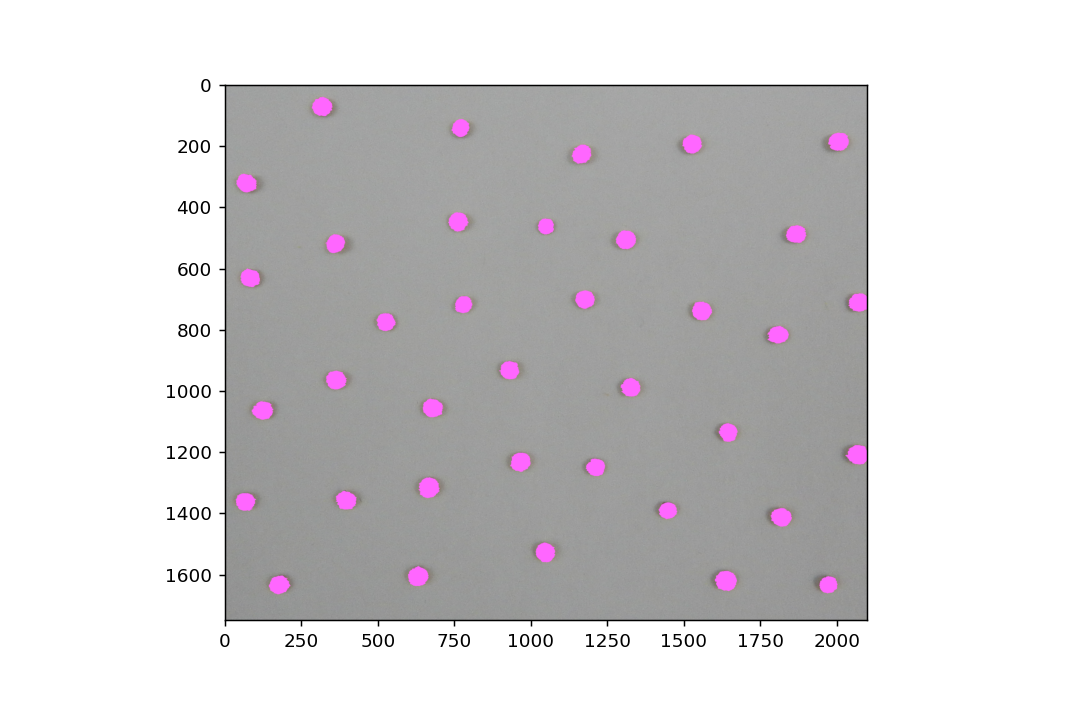

In [70]:
# Inputs:
#   img  = rgb image
#   mask = binary mask
objects2, obj_hierarchy = pcv.find_objects(img=img, mask=b_fill)

## Measure each seed

To measure each seed, iterate over the objects (which occur when obj_hierarchy[0][i][3] == -1). For each object, the following steps are done:

1. Contours are consolidated, so that all contours that correspond to one seed are compiled into a single object and mask.
2. Analyze seed shape
3. Analyze seed color

In [71]:
# Create a copy of the RGB image for shape analysis annotations
# Inputs:
#   img = image
shape_img = np.copy(img)

# Turn off plot debugging
pcv.params.debug = None

# Interate through all objects in objects2 and do a shape and color analysis
for i in range(0, len(objects2)):
    # Check to see if the object has an offshoot in the hierarchy
    if obj_hierarchy[0][i][3] == -1:
        # Create an object and a mask for one object
        #
        # Inputs:
        #   img - rgb image
        #   contours - list entry i in objects2
        #   hierarchy - np.array of obj_hierarchy[0][1]
        seed, seed_mask = pcv.object_composition(img=img, contours=[objects2[i]], hierarchy=np.array([[obj_hierarchy[0][i]]]))
        
        # Analyze shape of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   mask - mask created of single seed
        #   label - label for each seed in image
        shape_img = pcv.analyze_object(img=shape_img, obj=seed, mask=seed_mask, label=f"seed{i}")
        
        # Analyze color of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   hist_plot_type - 'all', or None for no histogram plot
        #   label - 'default'      
        color_img = pcv.analyze_color(rgb_img=img, mask=b_fill, hist_plot_type=None, label="default")
            

## Visualize shape analysis of seeds

Since debugging was turned off during the for loop, as plotting all analysis results significantly slows down the analysis, we can plot the final shape and color analyses to ensure that the results look correct.

<IPython.core.display.Javascript object>


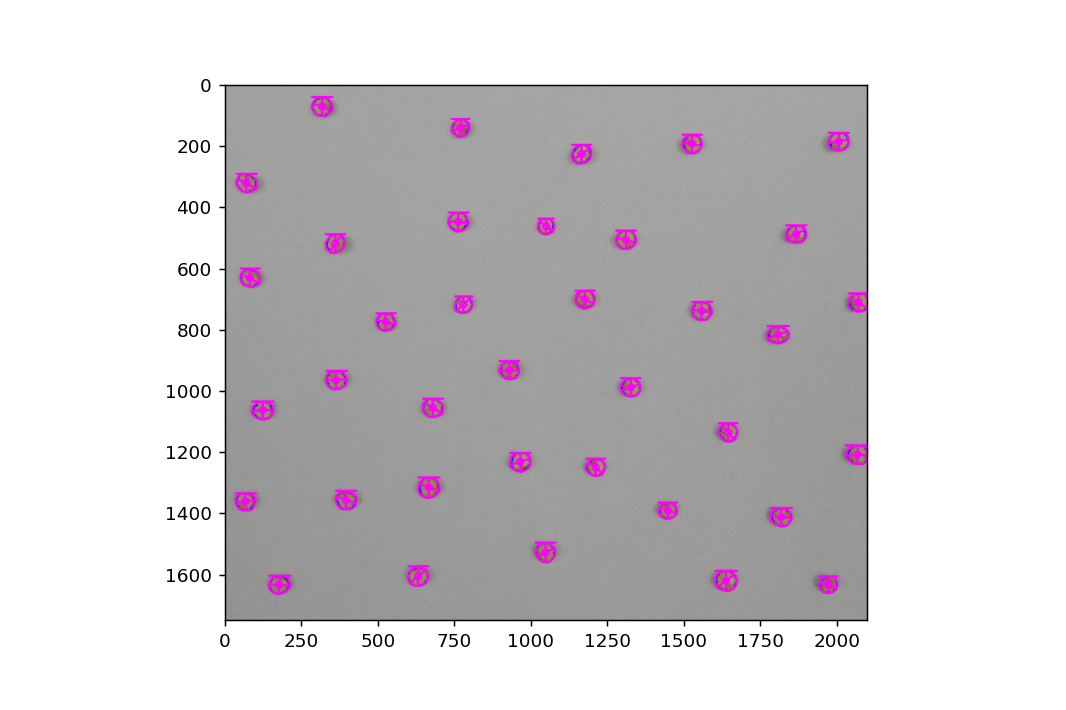

In [72]:
# Inputs:
#   img = image for shape analysis
pcv.plot_image(img=shape_img)

<IPython.core.display.Javascript object>


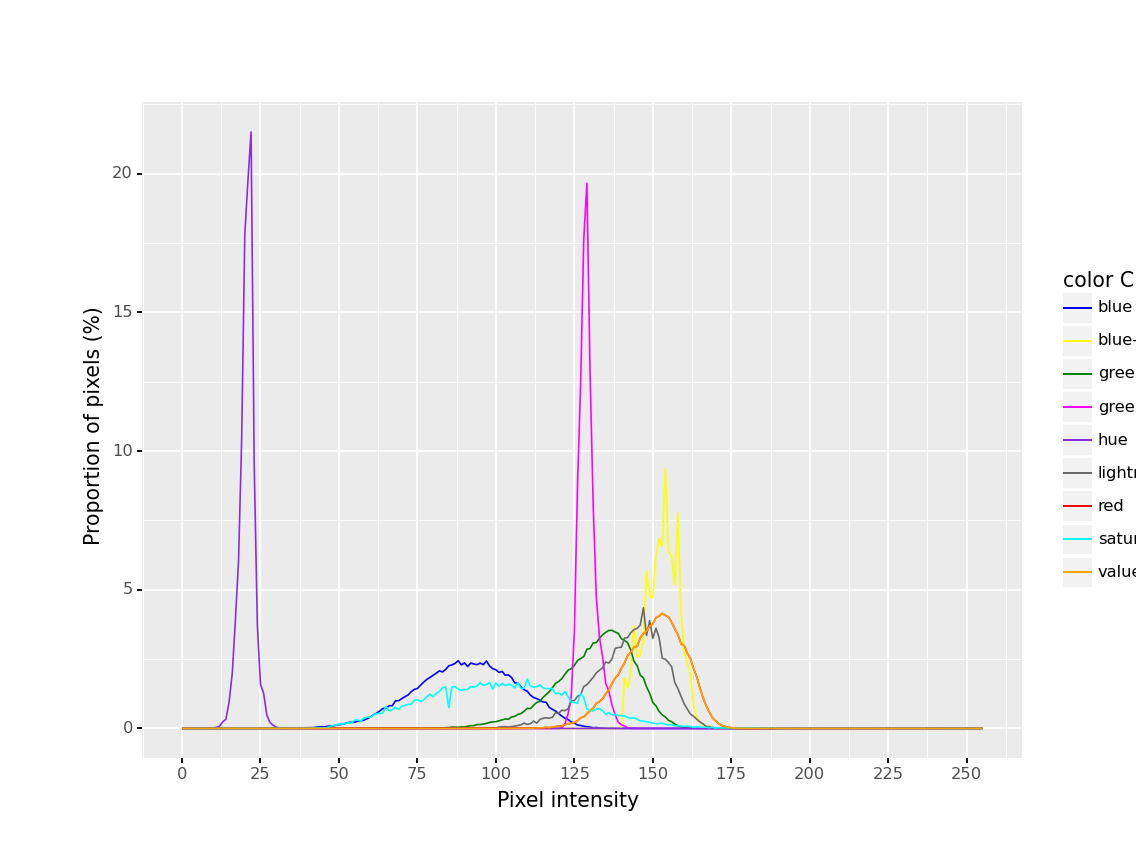

In [73]:
# Inputs:
#   img = image for color analysis
pcv.plot_image(img=color_img)

## Save results

During analysis, measurements are stored in the background in the outputs recorder.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object and color analysis using analyze_color.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [74]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result)